

***SIMULATION TRACKING:***
@ 100000.04999466843 yrs - Mass of star: 1.942919995788644 Msun
@ 200000.04997138536 yrs - Mass of star: 1.932522755667101 Msun
@ 300000.0499921725 yrs - Mass of star: 1.9213318031767441 Msun
@ 400000.0000853047 yrs - Mass of star: 1.909336548171653 Msun
@ 500000.000178437 yrs - Mass of star: 1.8965252632611038 Msun
@ 600000.0002715692 yrs - Mass of star: 1.8827273634056152 Msun
@ 700000.0003647015 yrs - Mass of star: 1.8678333754245526 Msun
@ 800000.0004578338 yrs - Mass of star: 1.8517524142143063 Msun
@ 900000.000550966 yrs - Mass of star: 1.8343540091308828 Msun
@ 1000000.0006440983 yrs - Mass of star: 1.8154401740158133 Msun
@ 1100000.0004977689 yrs - Mass of star: 1.7948447082693864 Msun
@ 1200000.0001252398 yrs - Mass of star: 1.7722476372843192 Msun
@ 1300000.0497527106 yrs - Mass of star: 1.7474780489936468 Msun
@ 1400000.0493801816 yrs - Mass of star: 1.7201876217857972 Msun
@ 1500000.0490076526 yrs - Mass of star: 1.6896704970170406 Msun
@ 160000

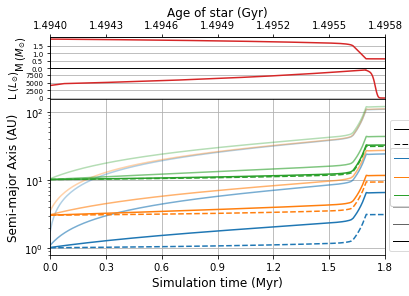

In [5]:
import mesa_reader as mr
import time
import rebound
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import reboundx
from matplotlib.lines import Line2D

# Extracts data about 2 Msun star from the SSE data file
star = open('evolve.data', 'r')

star_data = []
for line in star:
    star_data.append(line)

star_time = np.array([])
star_mass = np.array([])
star_luminosity = np.array([])


for i in star_data:
    star_time = np.append(star_time, (i.split(('  '))[0]))
    star_mass = np.append(star_mass, (i.split(('   '))[3]))
    star_luminosity = np.append(star_luminosity, (i.split(('   '))[4]))
    

star_time_corrected = np.array([])
star_luminosity_corrected = np.array([])
star_mass_corrected = np.array([])


for i in star_time:
    star_time_corrected = np.append(star_time_corrected, str( i).strip())

for i in star_luminosity:
    star_luminosity_corrected = np.append(star_luminosity_corrected, str( i).strip())

for i in star_mass:
    star_mass_corrected = np.append(star_mass_corrected, str( i).strip())


star_time = star_time_corrected.astype(np.float)
star_luminosity = star_luminosity_corrected.astype(np.float)
star_mass = star_mass_corrected.astype(np.float)

star_lum = np.array([])
star_age = np.array([])

for i in star_luminosity:
    star_lum = np.append(star_lum, 10**i)



for i in star_time:
    star_age = np.append(star_age, i*(10**6))
    
lumins = np.zeros(star_lum.size)       # convert W to sim units
for i, w in enumerate(star_lum):
    lumins[i] = (w * 3.828e26)   
    
sim = rebound.Simulation()

sp = sim.particles
sim.units = ('yr', 'AU', 'Msun') 
sim.integrator = "whfast"
sim.dt = .05 
sim.testparticle_type = 1

sim.add(m=1.99) 
sim.N_active = sim.N
sim.add(a= 30) #The particle at this index always goes crazy so this is just here as a placeholder
sim.add(a=1)
sim.add(a=1)
sim.add(a=1)
sim.add(a=1)
sim.add(a=3)
sim.add(a=3)
sim.add(a=3)
sim.add(a=3)
sim.add(a=10)
sim.add(a=10)
sim.add(a=10)
sim.add(a=10)


sim.move_to_com()

#################
start_age = 1.494e9 #This is the age of our 2 Msun star when the AGB phase begins
#################

#Lists will track the semim-major axes of all bodies in the sim

changing_a_one_10 = []
changing_a_one_100 = []
changing_a_one_1000 = []
changing_a_one_yarkless = []

changing_a_three_10 = []
changing_a_three_100 = []
changing_a_three_1000 = []
changing_a_three_yarkless = []

changing_a_ten_10 = []
changing_a_ten_100 = []
changing_a_ten_1000 = []
changing_a_ten_yarkless = []

#Add the Yarkovsky effect from REBx to each particle and then the sim
rebx = reboundx.Extras(sim)

mass_eq = reboundx.Interpolator(rebx, star_age, star_mass, 'spline')
luminosity_eq = reboundx.Interpolator(rebx, star_age, lumins, 'spline')

au_conv = 1.495978707e11 #m
yr_conv = 31557600 #sec
msun_conv = 1.9884e30 #kg

albedo = 0
density = 3000*((au_conv**3)/msun_conv)
radius_10 = 10/au_conv
radius_100 = 100/au_conv 
radius_1000 = 1000/au_conv
c = (2.998e8*yr_conv)/au_conv #speed of light
lstar = ((luminosity_eq.interpolate(rebx,t=sim.t+start_age)*yr_conv**3)/(msun_conv*au_conv**2))

#NOTE: 1 Lsun = .00027 in AU/Msun/yr units

yark = rebx.load_force("yarkovsky_effect")

yark.params["ye_c"] = c #set on the sim and not a particular particle
yark.params["ye_lstar"] = lstar #set on the sim and not a particular particle

#would've been better to loop these somehow but oh well

sp[3].params["ye_flag"] = 1 #setting this flag to 1 will give us the max outward version of the effect 
sp[3].params["ye_body_density"] = density
sp[3].params["ye_albedo"] = albedo
sp[3].r = radius_10 #remember radius is not inputed as a Rebx parameter - it's inputed on the particle in the Rebound sim 

sp[4].params["ye_flag"] = 1 
sp[4].params["ye_body_density"] = density
sp[4].params["ye_albedo"] = albedo
sp[4].r = radius_100 

sp[5].params["ye_flag"] = 1 
sp[5].params["ye_body_density"] = density
sp[5].params["ye_albedo"] = albedo
sp[5].r = radius_1000 

sp[7].params["ye_flag"] = 1 
sp[7].params["ye_body_density"] = density
sp[7].params["ye_albedo"] = albedo
sp[7].r = radius_10 

sp[8].params["ye_flag"] = 1 
sp[8].params["ye_body_density"] = density
sp[8].params["ye_albedo"] = albedo
sp[8].r = radius_100 

sp[9].params["ye_flag"] = 1  
sp[9].params["ye_body_density"] = density
sp[9].params["ye_albedo"] = albedo
sp[9].r = radius_1000 

sp[11].params["ye_flag"] = 1 
sp[11].params["ye_body_density"] = density
sp[11].params["ye_albedo"] = albedo
sp[11].r = radius_10 

sp[12].params["ye_flag"] = 1  
sp[12].params["ye_body_density"] = density
sp[12].params["ye_albedo"] = albedo
sp[12].r = radius_100 

sp[13].params["ye_flag"] = 1 
sp[13].params["ye_body_density"] = density
sp[13].params["ye_albedo"] = albedo
sp[13].r = radius_1000 


rebx.add_force(yark) #adds the force to the simulation

print("\n\n***SIMULATION TRACKING:***")
timer_start = time.perf_counter() #Start of timer

while sim.t < 1.8e6: #determines how many years the simulation goes for
        sim.step() #moves simulation forward a time step
        sim.integrator_synchronize() #synchronizes all changes in the particles during the simulation
        sp[0].m = mass_eq.interpolate(rebx, t=start_age+sim.t) #changes the mass of the Sun
        if (sim.t % 1e4) < 0.05: # every 1000 yrs
            changing_a_one_yarkless.append(sp[2].a) #adds semi-major axis to list every thousand years
            changing_a_one_10.append(sp[3].a)
            changing_a_one_100.append(sp[4].a)
            changing_a_one_1000.append(sp[5].a)
            changing_a_three_yarkless.append(sp[6].a)
            changing_a_three_10.append(sp[7].a)
            changing_a_three_100.append(sp[8].a)
            changing_a_three_1000.append(sp[9].a)
            changing_a_ten_yarkless.append(sp[10].a)
            changing_a_ten_10.append(sp[11].a)
            changing_a_ten_100.append(sp[12].a)
            changing_a_ten_1000.append(sp[13].a)
        if (sim.t % 1e5) < 0.05: #every 10000 yrs:
            print("@", sim.t, "yrs -", "Mass of star:", mass_eq.interpolate(rebx, t=start_age+sim.t), "Msun") #prints out data for sim and star

timer_end = time.perf_counter() 
runtime = timer_end - timer_start

print("\n***SIMULATION SUMMARY:***")
print("System's final age:", (sim.t + start_age)/1e9, "Gyr")
print("Total simulation time:", sim.t/1e6, "Myr")
print("Total runtime:", runtime, "sec")
print("              ", (runtime / 60), "min")
print("              ", ((runtime / 60) / 60), "hr")
print("Star's final mass:", sim.particles[0].m, "Msun") 


#Plots all graphs on one chart
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,sharex=True, gridspec_kw={'height_ratios': [2, 2, 10]})
fig.subplots_adjust(hspace=0)

plt.xlim(1.494, 1.4958)

corrected_star_age = (star_age/1e9) #changes units to Gyr

ax1.plot(corrected_star_age, star_mass, color = 'tab:red')
ax1.set_ylabel("M ($M_{\odot}$)", fontsize='medium')
ax1.grid()
ax1.yaxis.set_ticks(np.arange(0, 2, .5))
ax1.tick_params(axis='y', labelsize= 7)

ax2.plot(corrected_star_age, star_lum, color = 'tab:red')
ax2.set_ylabel('L ($L_{\odot}$)', fontsize='medium')
ax2.grid()
ax2.yaxis.set_ticks(np.arange(0, 10000, 2500))
ax2.tick_params(axis='y', labelsize= 7)


corrected_time = sim.t/1e6 #changes the units from yr to Myr
         
#1AU asteroid
ax3.plot(np.linspace(0, corrected_time, len(changing_a_one_yarkless)),
         changing_a_one_yarkless, '-', color = 'tab:blue', linestyle = '--', label = 'a = 1 AU (no yark)') 
ax3.plot(np.linspace(0, corrected_time, len(changing_a_one_10)),
         changing_a_one_10, color = 'tab:blue', alpha = .35)
ax3.plot(np.linspace(0, corrected_time, len(changing_a_one_100)),
         changing_a_one_100, color = 'tab:blue', alpha = .6)
ax3.plot(np.linspace(0, corrected_time, len(changing_a_one_1000)),
         changing_a_one_1000, color = 'tab:blue', alpha = 1.0, label = 'a = 1 AU')  
         
#3AU asteroid
ax3.plot(np.linspace(0, corrected_time, len(changing_a_three_yarkless)),
         changing_a_three_yarkless, '-', color = 'tab:orange', linestyle = '--', label = 'a = 3 AU (no yark)') 
ax3.plot(np.linspace(0, corrected_time, len(changing_a_three_10)),
         changing_a_three_10, color = 'tab:orange', alpha = .35)
ax3.plot(np.linspace(0, corrected_time, len(changing_a_three_100)),
         changing_a_three_100, color = 'tab:orange', alpha = .6)
ax3.plot(np.linspace(0, corrected_time, len(changing_a_three_1000)),
         changing_a_three_1000, color = 'tab:orange', alpha = 1.0, label = 'a = 3 AU')

#10AU asteroid
ax3.plot(np.linspace(0, corrected_time, len(changing_a_ten_yarkless)),
         changing_a_ten_yarkless, color = 'tab:green', linestyle = '--', label = 'a = 10 AU (no yark)')  
ax3.plot(np.linspace(0, corrected_time, len(changing_a_ten_10)),
         changing_a_ten_10, color = 'tab:green', alpha = .35)
ax3.plot(np.linspace(0, corrected_time, len(changing_a_ten_100)),
         changing_a_ten_100, color = 'tab:green', alpha = .6)
ax3.plot(np.linspace(0, corrected_time, len(changing_a_ten_1000)),
         changing_a_ten_1000, color = 'tab:green', alpha = 1.0, label = 'a = 10 AU')
         
plt.ylabel('Semi-major Axis (AU)', fontsize='large')
plt.xlabel('Simulation time (Myr)', fontsize = 'large')
plt.grid()
ax3.set_yscale('log')
ax3.xaxis.set_ticks(np.linspace(0, 1.8, 7))
             
###### LEGENDS ######

#first legend      
first_legend_elements = [Line2D([0], [0], color='black', alpha=0.35, lw=1.0, label='$R_{ast}$ = 10m'),
                         Line2D([0], [0], color='black', alpha=0.6,  lw=1.0, label='$R_{ast}$ = 100m'), 
                         Line2D([0], [0], color='black', alpha=1.0,  lw=1.0, label='$R_{ast}$ = 1000m')]                                  
first_legend = plt.legend(handles=first_legend_elements, bbox_to_anchor=(1, 0), loc='lower left', framealpha = .7, prop={"size": 8.5})
plt.gca().add_artist(first_legend)


#second legend
second_legend_elements = [Line2D([0], [0], color='black', lw=1.0, label='yark'),
                          Line2D([0], [0], color='black', lw=1.0, label='no yark', linestyle = '--', )]                                                           
second_legend = plt.legend(handles=second_legend_elements, bbox_to_anchor=(1,.9), loc = 'upper left', framealpha = .7, prop={"size": 10})
plt.gca().add_artist(second_legend)  


#third legend
third_legend_elements = [Line2D([0], [0], color='tab:blue',   lw=1.0, label='$a_{0}$ = 1 AU'),
                         Line2D([0], [0], color='tab:orange', lw=1.0, label='$a_{0}$ = 3 AU'), 
                         Line2D([0], [0], color='tab:green',  lw=1.0, label='$a_{0}$ = 10 AU')]                                                               
third_legend = plt.legend(handles=third_legend_elements, bbox_to_anchor=(1,.5), loc = 'center left', framealpha = .7, prop={"size": 9.5})
plt.gca().add_artist(third_legend) 

ax4 = ax1.twiny()
ax4.set_xlabel('Age of star (Gyr)', fontsize = 'large')
plt.xlim(1.494, 1.4958)
ax4.xaxis.set_ticks(np.arange(1.494, 1.4958, .0003))

plt.savefig('images/fig3.eps', bbox_inches='tight', pad_inches=1.25)
plt.savefig('images/fig3.pdf', bbox_inches='tight', pad_inches=1.25)
plt.savefig('images/fig3.png', bbox_inches='tight', pad_inches=1.25, dpi=300)	